In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import applications

from keras.optimizers import Adam, SGD, RMSprop

In [3]:
image_size_sq = 96
no_channels = 3

## Loading training datasets

In [4]:
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Gen_Classification'

# Creating numpy binary file to store preprocessed images for quicker loading
FF_data_bin = os.path.join(DATA_PATH,
        f'FF_data.npy')
NoF_data_bin = os.path.join(DATA_PATH,
        f'NoF_data.npy')

print(f"Looking for file: {FF_data_bin}")

if not os.path.isfile(FF_data_bin):
  start = time.time()
  print("Loading FF images...")

  FF_training_data = []
  FF_path = os.path.join(DATA_PATH,'FireSubset')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      FF_training_data.append(np.asarray(image))

  x = FF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))

  
  FF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  FF_training_data = FF_training_data.astype(np.float32)
  #FF_training_data = FF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(FF_data_bin,FF_training_data)
  elapsed = time.time()-start

else:
  FF_training_data = np.load(FF_data_bin)
  print("Loaded FF previously saved...")

# No fire data

if not os.path.isfile(NoF_data_bin):
  start = time.time()
  print("Loading NoF images...")

  NoFF_training_data = []
  FF_path = os.path.join(DATA_PATH,'NoFire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      NoFF_training_data.append(np.asarray(image))
  
  
  x = NoFF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  
  NoFF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  NoFF_training_data = NoFF_training_data.astype(np.float32)
  #NoFF_training_data = NoFF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(NoF_data_bin,NoFF_training_data)
  elapsed = time.time()-start

else:
  NoFF_training_data = np.load(NoF_data_bin)
  print("Loaded NoFF previously saved...")


Looking for file: /content/drive/My Drive/projects/Gen_Classification/FF_data.npy
Loaded FF previously saved...
Loaded NoFF previously saved...


## Data prep

In [5]:
#Checking size of both classes
FF_size = FF_training_data.shape
print("Size of FF data:", FF_size[0])

NoF_size = NoFF_training_data.shape
print("Size of NoFF data:", NoF_size[0])



Size of FF data: 880
Size of NoFF data: 880


In [6]:
FF_size_Label = np.ones((FF_size[0], 1), dtype=int)
NoF_size_Label = np.zeros((NoF_size[0], 1), dtype=int)
print( FF_size_Label.shape[0], NoF_size_Label.shape[0])

880 880


In [7]:
from sklearn.model_selection import train_test_split
#fire label 1
train_data1, val_data1, train_label1, val_label1 = train_test_split(FF_training_data, FF_size_Label, test_size = 0.2, random_state=4, shuffle= True )
#Nofire label 2
train_data2, val_data2, train_label2, val_label2 = train_test_split(NoFF_training_data, NoF_size_Label, test_size = 0.2, random_state=4, shuffle= True )

In [8]:
print(train_data1.shape, train_data2.shape)
print(val_data1.shape, val_data2.shape)

(704, 96, 96, 3) (704, 96, 96, 3)
(176, 96, 96, 3) (176, 96, 96, 3)


In [9]:
train_data = np.concatenate((train_data1, train_data2), axis =0)
train_label = np.concatenate((train_label1, train_label2), axis=0)

val_data = np.concatenate((val_data1, val_data2), axis =0)
val_label = np.concatenate((val_label1, val_label2), axis=0)

In [10]:

#checking labeling
print(val_label1[0], val_label[0])
print(val_label2[0], val_label[239])
print(val_label.shape)

[1] [1]
[0] [0]
(352, 1)


In [11]:
# Training data and Validation data Size
train_data_length = train_data.shape[0]
val_data_length = val_data.shape[0] 
print(train_data.shape, train_data_length)
print(val_data.shape, val_data_length)

(1408, 96, 96, 3) 1408
(352, 96, 96, 3) 352


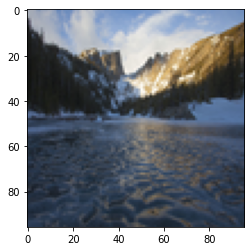

In [12]:
i = 158
x = np.reshape(train_data[995], (96,96,3))
img = x 
img = img.astype(np.uint8)
im = Image.fromarray(img)
plt.imshow(img)

In [13]:
train_datagen = ImageDataGenerator(
              rotation_range=10,
              width_shift_range=0.2,
              height_shift_range=0.2,
              rescale=1./255,
              #shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
BS = 32
Ep = 100
train_gen = train_datagen.flow(x = train_data, y=train_label, batch_size=BS)
validation_gen = test_datagen.flow(x = val_data, y= val_label, batch_size=BS)



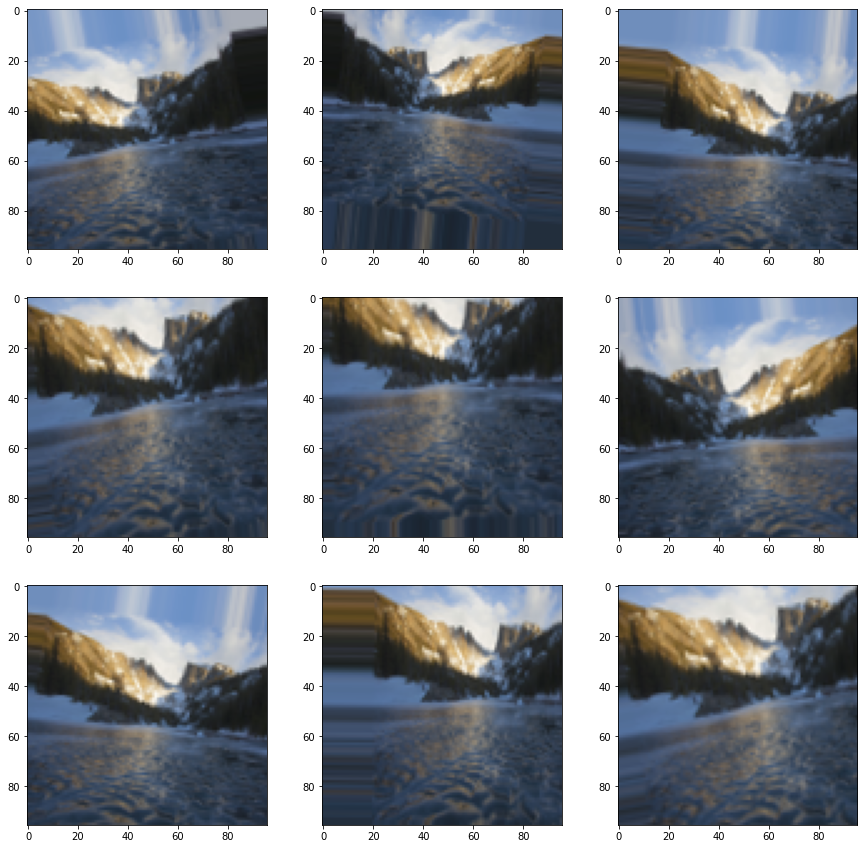

In [15]:
# ImageDataGenerator rotation
#datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
from matplotlib import pyplot
x = np.reshape(train_data[995], (1, 96,96, 3))
# iterator
aug_iter = train_datagen.flow(x, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(0, 9):

	# convert to unsigned integers
	#image = next(aug_iter)[0].astype('uint8') * 255
  pyplot.subplot(330 + 1 + i)
  #print(aug_iter[i].min(), aug_iter[i].max())
  pyplot.imshow(next(aug_iter).reshape(96,96,3))
	# plot image
	#ax[i].imshow(image)
	#ax[i].axis('off')

## 1. Basic CNN

In [16]:
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, SGD, RMSprop

def create_model():

  loss_func = binary_crossentropy
  #opt = RMSprop
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(96,96,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(optimizer='rmsprop', loss= loss_func, metrics=['accuracy'])
  return model

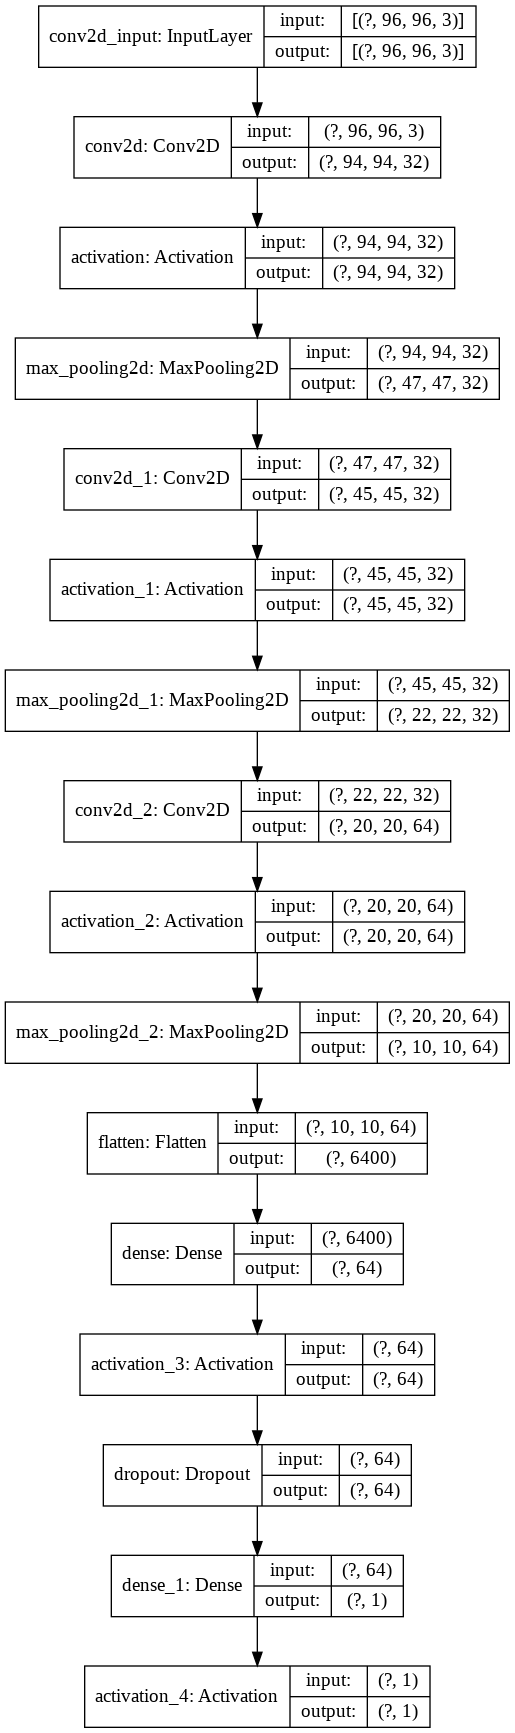

In [17]:
classifier = create_model()
plot_model(classifier, show_shapes=True, to_file='Classifier.png')

In [21]:
checkpoint_filepath = 'classifier/checkpoint'
checkpt = ModelCheckpoint(
                  filepath=checkpoint_filepath,
                  save_weights_only=True,
                  monitor='val_accuracy',
                  mode='max',
                  save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                      patience=75, verbose=1, mode='auto')

In [22]:
hist = classifier.fit(train_gen, steps_per_epoch= train_data_length // BS, 
                    epochs= Ep, verbose=1, validation_data=validation_gen,
                    validation_steps= val_data_length // BS, callbacks = [checkpt, early])

Epoch 1/100
44/44 [==============================] - 18s 408ms/step - loss: 0.7058 - accuracy: 0.5817 - val_loss: 0.6293 - val_accuracy: 0.6818
Epoch 2/100
44/44 [==============================] - 18s 406ms/step - loss: 0.6350 - accuracy: 0.6712 - val_loss: 0.7306 - val_accuracy: 0.5824
Epoch 3/100
44/44 [==============================] - 18s 401ms/step - loss: 0.5995 - accuracy: 0.7003 - val_loss: 0.5716 - val_accuracy: 0.7386
Epoch 4/100
44/44 [==============================] - 18s 409ms/step - loss: 0.5636 - accuracy: 0.7514 - val_loss: 0.4564 - val_accuracy: 0.7841
Epoch 5/100
44/44 [==============================] - 18s 402ms/step - loss: 0.5428 - accuracy: 0.7415 - val_loss: 0.4592 - val_accuracy: 0.8011
Epoch 6/100
44/44 [==============================] - 18s 401ms/step - loss: 0.4945 - accuracy: 0.7685 - val_loss: 0.3999 - val_accuracy: 0.8097
Epoch 7/100
44/44 [==============================] - 18s 403ms/step - loss: 0.4812 - accuracy: 0.7812 - val_loss: 0.4620 - val_accuracy:

In [23]:
classifier.save_weights("Gen_BasicCNN.h5")

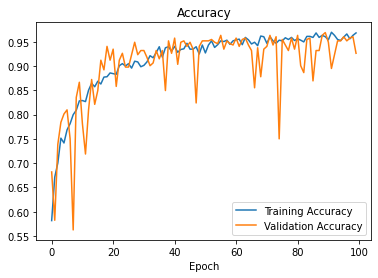

In [24]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
plt.title("Accuracy")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy","loss"])
plt.show()

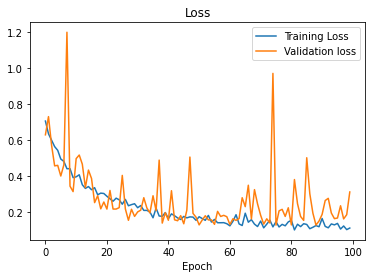

In [25]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation loss"])
plt.show()

### Validation Accuracy for basic CNN

In [125]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = classifier.predict_classes(test_data)
y_pred= y_pred.reshape(test_data.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(test_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(test_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(test_label, y_pred)))

Precision: 0.6887519260400616
Recall: 0.6
Accuracy: 0.6


# VGG

## Feature extraction

In [26]:
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, SGD

In [27]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(96,96,3))
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In [28]:
feature_ext_path = os.path.join(DATA_PATH,
                    f'feature_ext.npy')
feature_ext_val_path = os.path.join(DATA_PATH,
                    f'feature_ext_val.npy')
train_datagen = ImageDataGenerator(rescale=1./255)

generator = train_datagen.flow(x = train_data, y=train_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(generator, train_data_length // BS )
np.save(feature_ext_path, feature_ext)
print("Saved training features")

val_gen = train_datagen.flow(x = val_data, y=val_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(val_gen, val_data_length // BS )
np.save(feature_ext_val_path, feature_ext)
print("Saved validation features")

Instructions for updating:
Please use Model.predict, which supports generators.
Saved training features
Saved validation features


## 2. Training with pretrained vgg16

In [29]:
train_data_extracted = np.load(feature_ext_path)
val_data_extracted =  np.load(feature_ext_val_path)

print(train_data_extracted.shape, val_data_extracted.shape)

(1408, 3, 3, 512) (352, 3, 3, 512)


In [30]:
print(train_label1.shape, train_label2.shape, train_label.shape)

(704, 1) (704, 1) (1408, 1)


In [31]:
train_data_extracted.shape[1:]


(3, 3, 512)

In [32]:
from keras.optimizers import Adam, SGD, RMSprop
opt = RMSprop(learning_rate=0.0010)

model1 = Sequential()
model1.add(Flatten(input_shape= train_data_extracted.shape[1:]))
#model1.output_shape
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer=opt,
                  loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model1, show_shapes=True)

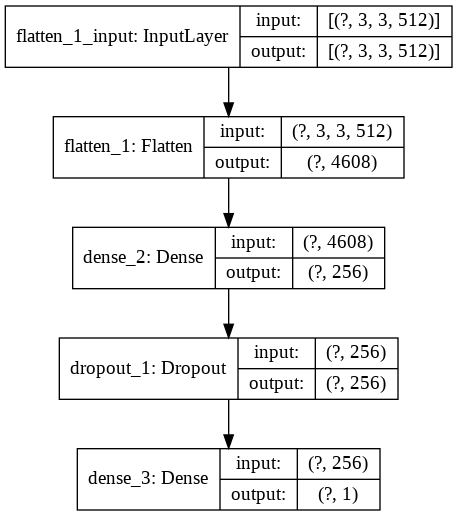

In [33]:
plot_model(model1, show_shapes=True)
#model1.output_shape

In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'classifier/checkpoint'
checkpt = ModelCheckpoint(
                  filepath=checkpoint_filepath,
                  save_weights_only=True,
                  monitor='val_accuracy',
                  mode='max',
                  save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                      patience=75, verbose=1, mode='auto')

In [35]:
epochs = 200
batch_size = 32
hist = model1.fit(train_data_extracted, train_label,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(val_data_extracted, val_label),
           callbacks=[checkpt,early])

Epoch 1/200
44/44 [==============================] - 1s 19ms/step - loss: 0.4420 - accuracy: 0.8736 - val_loss: 0.1604 - val_accuracy: 0.9460
Epoch 2/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1349 - accuracy: 0.9467 - val_loss: 0.1256 - val_accuracy: 0.9403
Epoch 3/200
44/44 [==============================] - 1s 17ms/step - loss: 0.1113 - accuracy: 0.9560 - val_loss: 0.0982 - val_accuracy: 0.9545
Epoch 4/200
44/44 [==============================] - 1s 16ms/step - loss: 0.0810 - accuracy: 0.9659 - val_loss: 0.0927 - val_accuracy: 0.9659
Epoch 5/200
44/44 [==============================] - 1s 16ms/step - loss: 0.0472 - accuracy: 0.9844 - val_loss: 0.0726 - val_accuracy: 0.9716
Epoch 6/200
44/44 [==============================] - 1s 15ms/step - loss: 0.0492 - accuracy: 0.9865 - val_loss: 0.0843 - val_accuracy: 0.9602
Epoch 7/200
44/44 [==============================] - 1s 16ms/step - loss: 0.0419 - accuracy: 0.9837 - val_loss: 0.0670 - val_accuracy: 0.9716
Epoch 

In [36]:
model1.save_weights("Gen_PreTrainedVGG.h5")

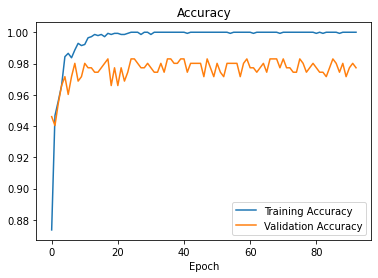

In [37]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
plt.title("Accuracy")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy","loss"])
plt.show()

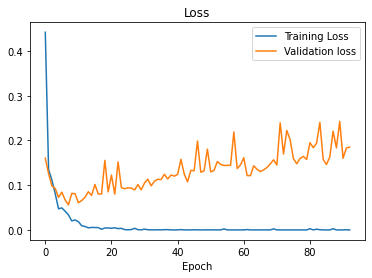

In [38]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation loss"])
plt.show()

## TEST

### Displaying images from FIRE and its classification

In [ ]:
image_size_sq = 96
testdata_fire = []
DATA_PATH = '/content/drive/My Drive/projects/Gen_Classification/test'
test_path = os.path.join(DATA_PATH,'fire')
for filename in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,filename)
    image = Image.open(path).resize((image_size_sq,
          image_size_sq),Image.ANTIALIAS)
    testdata_fire.append(np.asarray(image))

x = testdata_fire[1:]
y=[]
print(len(x))
#t = np.reshape(x, (-1,96,96,3))
for i in x:
  #print(i.shape)
  if i.shape != (96,96,3):
    print("False")
  else:
    y.append(i)

print(len(y))


testdata_fire = np.reshape(y,(-1,image_size_sq,
          image_size_sq,no_channels))
testdata_fire = testdata_fire.astype(np.float32)
#FF_training_data = FF_training_data / 127.5 - 1.

100%|██████████| 19/19 [00:04<00:00,  4.06it/s]

18
18


In [ ]:
test_data_length = testdata_fire.shape[0]
test_data_length

18

In [ ]:
#feature_ext = model.predict(generator)
BS = 1
test_data_length = testdata_fire.shape[0]
test_gen = train_datagen.flow(x = testdata_fire, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_data_length // BS )
feature_ext[1].shape

(3, 3, 512)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


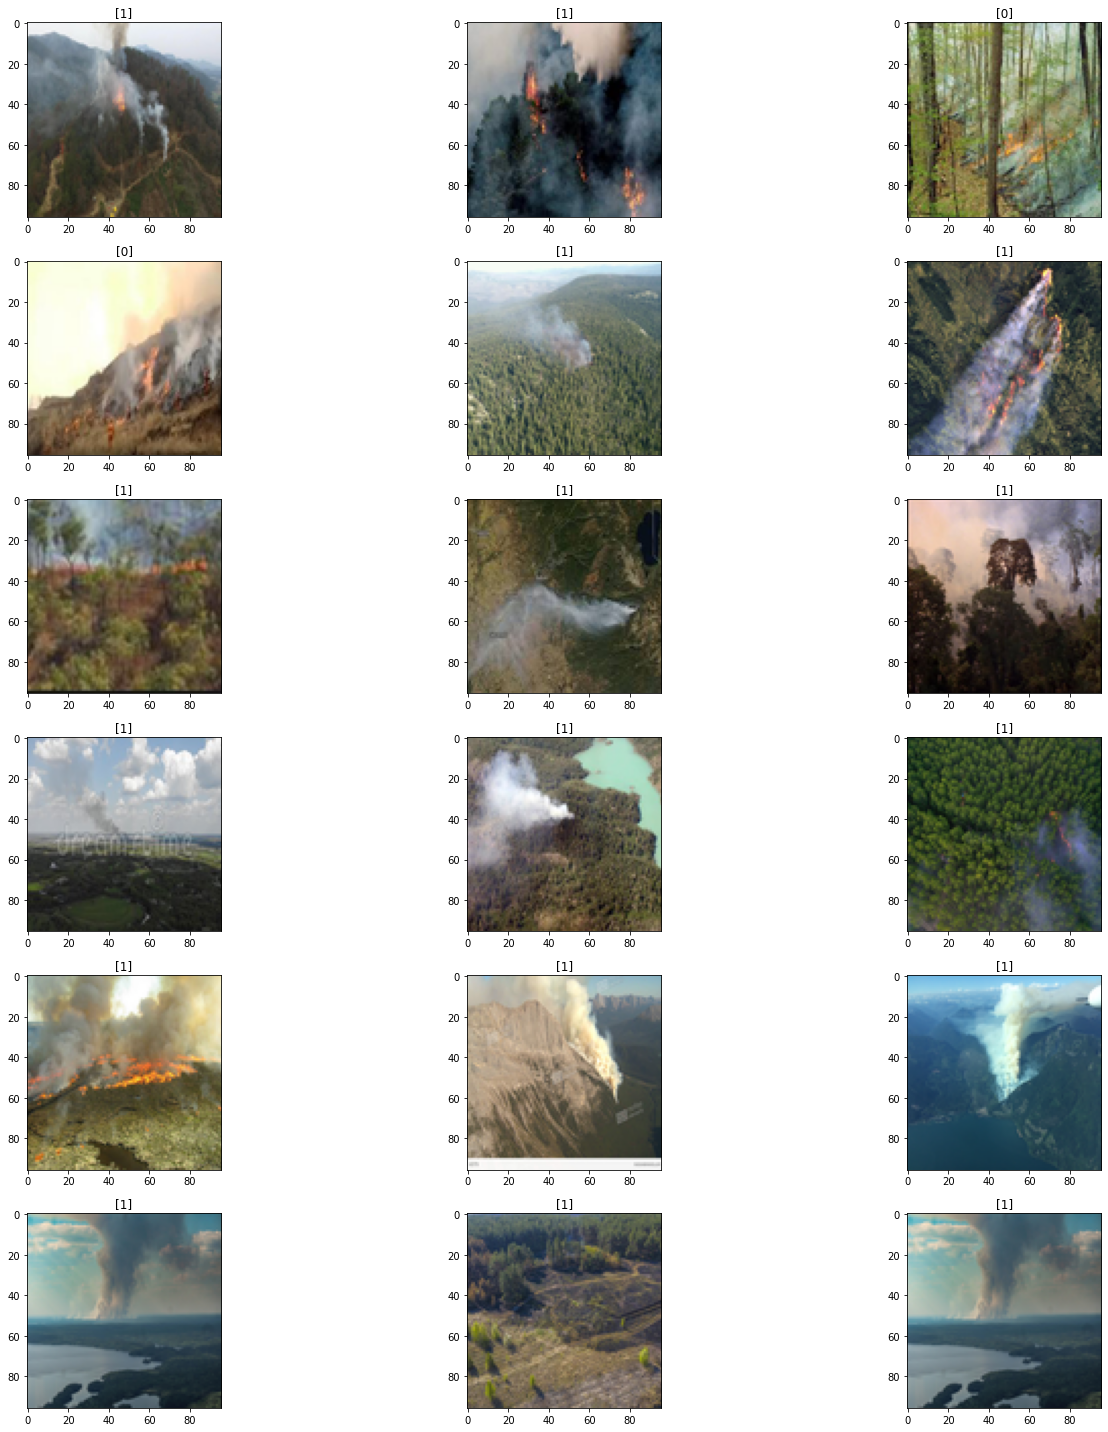

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,20))
l =  testdata_fire.shape[0]

#plt.figure(0)
count = 0;
for i in range(6):
    for j in range(3):
        plt.subplot2grid((6,3), (i,j))
        #ax[i,j].set_title('subplot 1')
        ax = plt.subplot2grid((6,3), (i,j))
        x = np.reshape(testdata_fire[count], (96,96,3))

        y = np.reshape(feature_ext[count], (1, 3,3,512))
        p = model1.predict_classes(y)
        

        #pred = model1.predict_classes(feature_ext[count])
        ax.set_title(p[0])
        #print("Class : ",pred)


        count = count + 1 
        img = x.astype(np.uint8)
        fig.tight_layout()
        pyplot.imshow(img)
plt.show()

###  Displaying images from No FIRE and its classification

In [ ]:
image_size_sq = 96
testdata_fire = []
DATA_PATH = '/content/drive/My Drive/projects/Gen_Classification/test'
test_path = os.path.join(DATA_PATH,'nofire')
for filename in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,filename)
    image = Image.open(path).resize((image_size_sq,
          image_size_sq),Image.ANTIALIAS)
    testdata_fire.append(np.asarray(image))

x = testdata_fire[1:]
y=[]
print(len(x))
#t = np.reshape(x, (-1,96,96,3))
for i in x:
  #print(i.shape)
  if i.shape != (96,96,3):
    print(False)
  else:
    y.append(i)

print(len(y))


testdata_fire = np.reshape(y,(-1,image_size_sq,
          image_size_sq,no_channels))
testdata_fire = testdata_fire.astype(np.float32)
#FF_training_data = FF_training_data / 127.5 - 1.

100%|██████████| 19/19 [00:05<00:00,  3.73it/s]

18
18


In [ ]:
BS = 1
test_data_length = testdata_fire.shape[0]
test_gen = train_datagen.flow(x = testdata_fire, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_data_length // BS )
feature_ext.shape

(18, 3, 3, 512)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


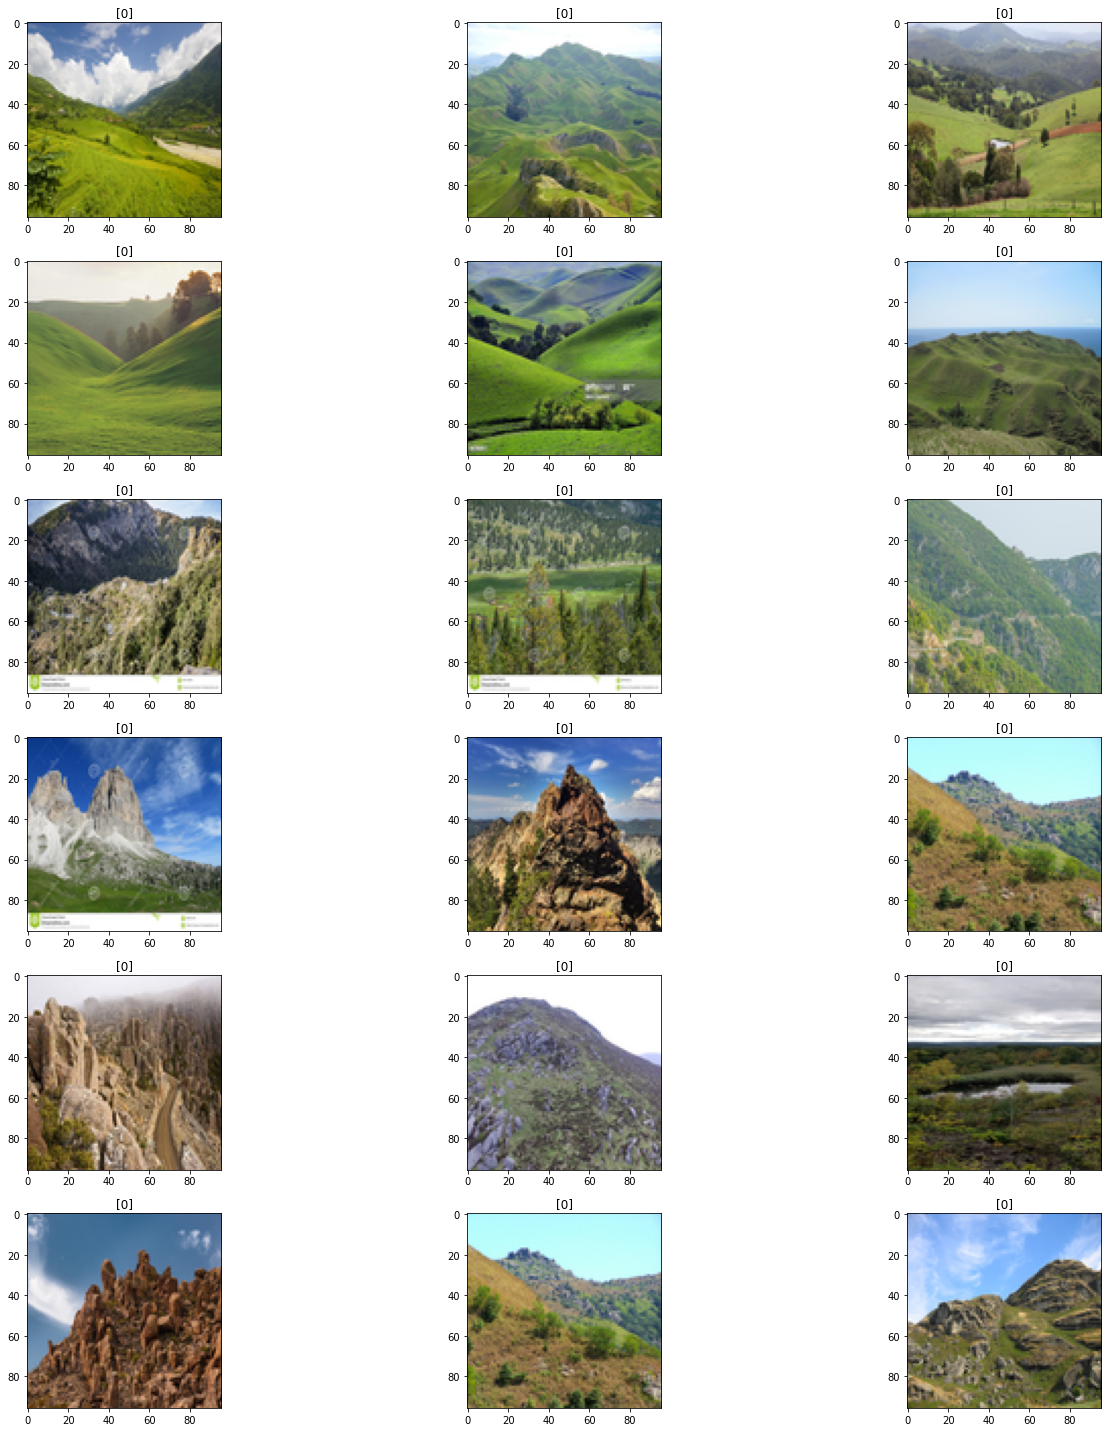

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,20))
l =  testdata_fire.shape[0]

#plt.figure(0)
count = 0;
for i in range(6):
    for j in range(3):
        plt.subplot2grid((6,3), (i,j))
        #ax[i,j].set_title('subplot 1')
        ax = plt.subplot2grid((6,3), (i,j))
        x = np.reshape(testdata_fire[count], (96,96,3))

        y = np.reshape(feature_ext[count], (1, 3,3,512))
        p = model1.predict_classes(y)
        

        #pred = model1.predict_classes(feature_ext[count])
        ax.set_title(p[0])
        #print("Class : ",pred)


        count = count + 1 
        img = x.astype(np.uint8)
        fig.tight_layout()
        pyplot.imshow(img)
plt.show()

### Validation Evaluation Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = model1.predict_classes(val_data_extracted)
y_pred= y_pred.reshape(val_data.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(val_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(val_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(val_label, y_pred)))

Precision: 0.9802531727322633
Recall: 0.9801136363636364
Accuracy: 0.9801136363636364


### Test dataset (common) Evaluation Metrics 

In [ ]:
#test_datapath = '/content/drive/My Drive/projects/test'
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Test'

# Creating numpy binary file to store preprocessed images for quicker loading
FFtest_data_bin = os.path.join(DATA_PATH,
        f'FF_data.npy')
NoFtest_data_bin = os.path.join(DATA_PATH,
        f'NoF_data.npy')

print(f"Looking for file: {FFtest_data_bin}")

if not os.path.isfile(FFtest_data_bin):
  start = time.time()
  print("Loading FF images...")

  FF_training_data = []
  FF_path = os.path.join(DATA_PATH,'fire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      FF_training_data.append(np.asarray(image))

  x = FF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))

  
  FF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  FF_training_data = FF_training_data.astype(np.float32)
  #FF_training_data = FF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(FFtest_data_bin,FF_training_data)
  elapsed = time.time()-start

else:
  FF_training_data = np.load(FFtest_data_bin)
  print("Loaded FF previously saved...")

# No fire data

if not os.path.isfile(NoFtest_data_bin):
  start = time.time()
  print("Loading NoF images...")

  NoFF_training_data = []
  FF_path = os.path.join(DATA_PATH,'nofire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      NoFF_training_data.append(np.asarray(image))
  
  
  x = NoFF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  
  NoFF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  NoFF_training_data = NoFF_training_data.astype(np.float32)
  #NoFF_training_data = NoFF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(NoFtest_data_bin,NoFF_training_data)
  elapsed = time.time()-start

else:
  NoFF_training_data = np.load(NoFtest_data_bin)
  print("Loaded NoFF previously saved...")


FFtest = FF_training_data
NoFTest = NoFF_training_data
#Checking size of both classes
FFtest_size = FFtest.shape
print("Size of FF data:", FFtest_size[0])
NoF_size = NoFTest.shape
print("Size of NoFF data:", NoF_size[0])

FFtest_Label = np.ones((FFtest_size[0], 1), dtype=int)
NoFtest_Label = np.zeros((NoF_size[0], 1), dtype=int)
print( FFtest_Label.shape[0], NoFtest_Label.shape[0])

Looking for file: /content/drive/My Drive/projects/Test/FF_data.npy
Loaded FF previously saved...
Loaded NoFF previously saved...
Size of FF data: 35
Size of NoFF data: 35
35 35


In [ ]:
test_data = np.concatenate((FF_training_data, NoFF_training_data), axis =0)
test_label = np.concatenate((FFtest_Label, NoFtest_Label), axis =0)
test_label_len = test_label.shape[0]


In [ ]:
BS = 1
test_gen = train_datagen.flow(x = test_data, y=test_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_label_len // BS )
np.save(feature_ext_val_path, feature_ext)
print("Saved test features")

Saved test features


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = model1.predict_classes(feature_ext)
y_pred= y_pred.reshape(test_label.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(test_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(test_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(test_label, y_pred)))

Precision: 0.9156429156429157
Recall: 0.9142857142857143
Accuracy: 0.9142857142857143


## 3. Transfer Learning with fine tuned VGG16 model

In [39]:
model1.save_weights("top_model_weights_path.h5")

In [40]:
modelnew = applications.VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))
#model = applications.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
modelnew.summary()

Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128

In [41]:
#wholemodel = applications.VGG16(weights='imagenet')
#plot_model( wholemodel, show_shapes=True)


In [42]:
top_model = Sequential()
top_model.add(Flatten(input_shape=(3,3,512)))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.summary()
#top_model.load_weights("top_model_weights_path.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,180,161
Trainable params: 1,180,161
Non-trainable params: 0
_________________________________________________________________


In [43]:
top_model.load_weights("top_model_weights_path.h5")

In [44]:
seqmodel = Sequential()
for layer in modelnew.layers:
  seqmodel.add(layer)

In [45]:
seqmodel.add(top_model)

In [46]:
seqmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

In [47]:
for layer in seqmodel.layers[:25]:
    layer.trainable = False

In [48]:
seqmodel.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [49]:
train_datagen = ImageDataGenerator(
              rotation_range=10,
              width_shift_range=0.2,
              height_shift_range=0.2,
              rescale=1./255,
              #shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [50]:
train_gen = train_datagen.flow(x = train_data, y=train_label, batch_size=BS)
validation_gen = test_datagen.flow(x = val_data, y= val_label, batch_size=BS)

In [51]:
Ep = 10
hist = seqmodel.fit_generator(
        train_gen, steps_per_epoch= train_data_length // BS, 
        epochs= Ep, verbose=1, validation_data=validation_gen,
        validation_steps= val_data_length // BS )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
44/44 [==============================] - 161s 4s/step - loss: 0.8202 - accuracy: 0.9382 - val_loss: 0.1852 - val_accuracy: 0.9773
Epoch 2/10
44/44 [==============================] - 164s 4s/step - loss: 0.9358 - accuracy: 0.9276 - val_loss: 0.1852 - val_accuracy: 0.9773
Epoch 3/10
44/44 [==============================] - 161s 4s/step - loss: 0.9048 - accuracy: 0.9247 - val_loss: 0.1852 - val_accuracy: 0.9773
Epoch 4/10
44/44 [==============================] - 162s 4s/step - loss: 0.8485 - accuracy: 0.9311 - val_loss: 0.1852 - val_accuracy: 0.9773
Epoch 5/10
44/44 [==============================] - 162s 4s/step - loss: 0.9949 - accuracy: 0.9226 - val_loss: 0.1852 - val_accuracy: 0.9773
Epoch 6/10
44/44 [==============================] - 162s 4s/step - loss: 1.0830 - accuracy: 0.9155 - val_loss: 0.1852 - val_accuracy: 0.9773
Epoch 7/10
44/44 [==============================] - 163s 4s/step - loss: 0.945

In [52]:
seqmodel.save_weights("Gen_FineTunedVGG.h5")

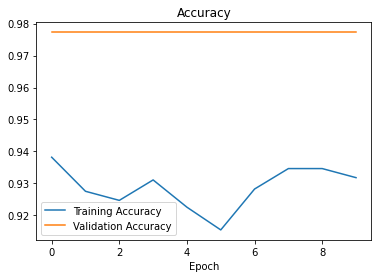

In [53]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
plt.title("Accuracy")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy","loss"])
plt.show()

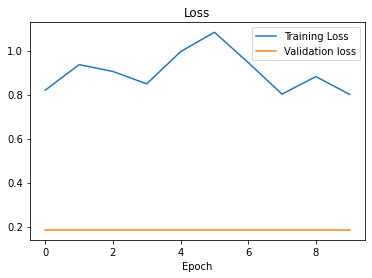

In [54]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
#plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation loss"])
plt.show()

## TEST

### Test dataset (common) Evaluation Metrics 

In [55]:
#test_datapath = '/content/drive/My Drive/projects/test'
# Path for data from Google Drive

DATA_PATH = '/content/drive/My Drive/projects/Test'

# Creating numpy binary file to store preprocessed images for quicker loading
FFtest_data_bin = os.path.join(DATA_PATH,
        f'FF_data.npy')
NoFtest_data_bin = os.path.join(DATA_PATH,
        f'NoF_data.npy')

print(f"Looking for file: {FFtest_data_bin}")

if not os.path.isfile(FFtest_data_bin):
  start = time.time()
  print("Loading FF images...")

  FF_training_data = []
  FF_path = os.path.join(DATA_PATH,'fire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      FF_training_data.append(np.asarray(image))

  x = FF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))

  
  FF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  FF_training_data = FF_training_data.astype(np.float32)
  #FF_training_data = FF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(FFtest_data_bin,FF_training_data)
  elapsed = time.time()-start

else:
  FF_training_data = np.load(FFtest_data_bin)
  print("Loaded FF previously saved...")

# No fire data

if not os.path.isfile(NoFtest_data_bin):
  start = time.time()
  print("Loading NoF images...")

  NoFF_training_data = []
  FF_path = os.path.join(DATA_PATH,'nofire')
  for filename in tqdm(os.listdir(FF_path)):
      path = os.path.join(FF_path,filename)
      image = Image.open(path).resize((image_size_sq,
            image_size_sq),Image.ANTIALIAS)
      NoFF_training_data.append(np.asarray(image))
  
  
  x = NoFF_training_data[1:]
  y=[]
  print(len(x))
  #t = np.reshape(x, (-1,96,96,3))
  for i in x:
    #print(i.shape)
    if i.shape != (96,96,3):
      print(False)
    else:
      y.append(i)

  print(len(y))
  
  
  NoFF_training_data = np.reshape(y,(-1,image_size_sq,
            image_size_sq,no_channels))
  NoFF_training_data = NoFF_training_data.astype(np.float32)
  #NoFF_training_data = NoFF_training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(NoFtest_data_bin,NoFF_training_data)
  elapsed = time.time()-start

else:
  NoFF_training_data = np.load(NoFtest_data_bin)
  print("Loaded NoFF previously saved...")


FFtest = FF_training_data
NoFTest = NoFF_training_data
#Checking size of both classes
FFtest_size = FFtest.shape
print("Size of FF data:", FFtest_size[0])
NoF_size = NoFTest.shape
print("Size of NoFF data:", NoF_size[0])

FFtest_Label = np.ones((FFtest_size[0], 1), dtype=int)
NoFtest_Label = np.zeros((NoF_size[0], 1), dtype=int)
print( FFtest_Label.shape[0], NoFtest_Label.shape[0])

Looking for file: /content/drive/My Drive/projects/Test/FF_data.npy
Loaded FF previously saved...
Loaded NoFF previously saved...
Size of FF data: 35
Size of NoFF data: 35
35 35


In [56]:
test_data = np.concatenate((FF_training_data, NoFF_training_data), axis =0)
test_label = np.concatenate((FFtest_Label, NoFtest_Label), axis =0)
test_label_len = test_label.shape[0]


In [57]:
BS = 1
test_gen = train_datagen.flow(x = test_data, y=test_label, batch_size=BS, shuffle=False)
feature_ext = model.predict_generator(test_gen, test_label_len // BS )
np.save(feature_ext_val_path, feature_ext)
print("Saved test features")

Saved test features


In [58]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
#Predictions
#y_pred = model1.predict(val_data).argmax(-1)
y_pred = seqmodel.predict_classes(test_data)
y_pred= y_pred.reshape(test_label.shape[0],1)

#Metrics
#loss, acc = seqmodel.evaluate(val_data,  val_label, verbose=1)
#print('\model, accuracy: {:5.2f}%'.format(100*acc))

print("Precision: "+ str(precision_score(test_label, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(test_label, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(test_label, y_pred)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Precision: 0.7611940298507462
Recall: 0.5428571428571428
Accuracy: 0.5428571428571428
